In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import random
from scipy.interpolate import UnivariateSpline  
import pickle
from sklearn.decomposition import PCA
import time
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

# 218 94

# 155 70


class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 30 # number of hidden states
        self.n_layers = 4 # number of LSTM layers (stacked)
        self.dropout = nn.Dropout(0.1) 

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True
                                 )
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 200)
        self.sigmoid = nn.Sigmoid()
     
        


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        #lstm_out, self.hidden = self.l_lstm(x)
        
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.sigmoid(self.l_linear(x))
    
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    
    for i in range(0,len(sequences), 200):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if i!=0 and end_ix > len(sequences):
            break
        sequences[i:end_ix,0]=np.insert(np.diff(sequences[i:end_ix,0]),0,0)
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-60], sequences[end_ix-60:end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#read training data#############################################################################################
df3 = pd.read_csv('train_round_10_28.csv')
df3.head()
df3.info()
df3 = df3[["Date","Province_State","Confirmed","Deaths"]]
df3.columns = ["Date","Province_State","Confirmed","Deaths"]


#read testing data##############################################################################################
df4 = pd.read_csv('test_200.csv')
df4.head()
df4.info()
df4 = df4[["Date","Province_State","Confirmed","Deaths"]]
df4.columns = ["Date","Province_State","Confirmed","Deaths"]

is_texas =  (df4['Province_State']=='California')

#training data filtering#########################################################################################
state_list = [i for i in list(df3["Province_State"].unique()) if i != "Texas"]
data=df3[df3.Province_State.isin(["California"])][['Confirmed','Deaths']]


#testing data filtering#########################################################################################
data2=df4[(is_texas)][['Confirmed','Deaths']]
date=df4[(is_texas)][['Date','Confirmed']]

date.Date = pd.to_datetime(date.Date,format='%m%d%Y', errors='ignore')
date.set_index('Date', inplace=True)
################################################################################################################

n_features = 2 # this is number of parallel inputs
n_timesteps = 200 # this is number of timesteps


#input splitting################################################################################################
X, Y = split_sequences(data.values, n_timesteps)

print (X.shape,Y.shape)

#normalization##################################################################################################
alld=np.concatenate((X,Y),1)
alld=alld.reshape(alld.shape[0]*alld.shape[1],alld.shape[2])



scaler = MinMaxScaler()
scaler.fit(alld)
X=[scaler.transform(x) for x in X]
y=[scaler.transform(y) for y in Y]

X=np.array(X)
y=np.array(y)[:,:,0]


#training#########################################################################################

mv_net = MV_LSTM(n_features, 140).cuda()

criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-3)

train_episodes = 1000

batch_size = 16

mv_net.train()

for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        p = np.random.permutation(len(X))
        inpt = X[p][b:b+batch_size,:,:]
        target = y[p][b:b+batch_size,:]    
        x_batch = torch.tensor(inpt,dtype=torch.float32).cuda()    
        y_batch = torch.tensor(target,dtype=torch.float32).cuda()
        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        all_batch=torch.cat((x_batch[:,:,0], y_batch), 1)
        loss = 1000*criterion(output.view(-1), all_batch.view(-1))
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    print('step : ' , t , 'loss : ' , loss.item())


#evaluation#########################################################################################################



In [ ]:
def test_states(statename):
    #read training data#############################################################################################
  df3 = pd.read_csv('train_round_10_28.csv')
  df3 = df3[["Date","Province_State","Confirmed","Deaths"]]
  df3.columns = ["Date","Province_State","Confirmed","Deaths"]
  #read testing data##############################################################################################
  df4 = pd.read_csv('test_200.csv')
  df4 = df4[["Date","Province_State","Confirmed","Deaths"]]
  df4.columns = ["Date","Province_State","Confirmed","Deaths"]
  is_texas =  (df4['Province_State']==statename)
  #training data filtering#########################################################################################
  state_list = [i for i in list(df3["Province_State"].unique()) if i != "Texas"]
  data=df3[df3.Province_State.isin([statename])][['Confirmed','Deaths']]

  #testing data filtering#########################################################################################
  data2=df4[(is_texas)][['Confirmed','Deaths']]
  date=df4[(is_texas)][['Date','Confirmed']]
  date.Date = pd.to_datetime(date.Date,format='%m%d%Y', errors='ignore')
  date.set_index('Date', inplace=True)
  ################################################################################################################
  n_features = 2 # this is number of parallel inputs
  n_timesteps = 200 # this is number of timesteps
  #input splitting################################################################################################
  X, Y = split_sequences(data.values, n_timesteps)
  #normalization##################################################################################################
  alld=np.concatenate((X,Y),1)
  alld=alld.reshape(alld.shape[0]*alld.shape[1],alld.shape[2])
  scaler = MinMaxScaler()
  scaler.fit(alld)
  X=[scaler.transform(x) for x in X]
  y=[scaler.transform(y) for y in Y]
  X=np.array(X)
  y=np.array(y)[:,:,0]
  #training#########################################################################################
  mv_net = MV_LSTM(n_features, 140).cuda()
  criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
  optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-3)
  train_episodes = 1000
  batch_size = 16
  mv_net.train()
  for t in range(train_episodes):
      for b in range(0,len(X),batch_size):
          p = np.random.permutation(len(X))
          inpt = X[p][b:b+batch_size,:,:]
          target = y[p][b:b+batch_size,:]    
          x_batch = torch.tensor(inpt,dtype=torch.float32).cuda()    
          y_batch = torch.tensor(target,dtype=torch.float32).cuda()
          mv_net.init_hidden(x_batch.size(0))
          output = mv_net(x_batch) 
          all_batch=torch.cat((x_batch[:,:,0], y_batch), 1)
          loss = 1000*criterion(output.view(-1), all_batch.view(-1))
          loss.backward()
          optimizer.step()        
          optimizer.zero_grad() 
  data2x=data2
  truth = data2
  data2x.values[0:len(data2x),0]=np.insert(np.diff(data2x.values[0:len(data2x),0]),0,0)
  data2x=scaler.transform(data2x) 
  X_test = np.expand_dims(data2x, axis=0)
  mv_net.init_hidden(1)
  lstm_out = mv_net(torch.tensor(X_test[:,:140,:],dtype=torch.float32).cuda())
  lstm_out=lstm_out.reshape(1,200,1).cpu().data.numpy()
  actual_predictions = scaler.inverse_transform(np.tile(lstm_out, (1, 1, 2))[0])[:,0]
  with open('./predict_indo8.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
      pickle.dump(pd.Series(actual_predictions), f,protocol=2)
    #visualization####################################################################################################    
  fig, ax = plt.subplots() 
  plt.title('Days vs Confirmed Cases Accumulation')
  plt.ylabel('Confirmed')
  left, width = .25, .5
  bottom, height = .25, .5
  right = left + width
  top = bottom + height
  date_list=pd.date_range(start=date.index[0],end=date.index[-1])
  plt.axvline(x=np.array(date_list)[154], color='r', linestyle='--')
  ax.text(0.2*(left+right), 0.8*(bottom+top), 'input sequence',
          horizontalalignment='left',
          verticalalignment='center',
          fontsize=10, color='red',
          transform=ax.transAxes)
  ax.text(0.0125*(left+right), 0.77*(bottom+top), '______________________',
          horizontalalignment='left',
          verticalalignment='center',
          fontsize=20, color='red',
          transform=ax.transAxes)
  sumpred=np.cumsum(np.absolute(actual_predictions))
  print (date.values.shape) 
  # print ("MAPE: ",100 * np.mean(np.absolute(date.Confirmed[-25:]-sumpred[-25:]-113948) / date.Confirmed[-25:]))          
  plt.plot(np.array(date_list),sumpred,label='Prediction')
  plt.plot(np.array(date_list),date.Confirmed,label='Actual')
  plt.xticks(rotation=90)
  fig.autofmt_xdate()
  plt.legend(loc=2)
  plt.show() 
  min = 1000000
  i_m = 0
  import math
  a = math.floor(date.Confirmed[-1]-sumpred[-1])
  b = math.floor(date.Confirmed[-25]-sumpred[-25])
  if b < a:
    temp = a
    a = b
    b = temp
  for i in range(a, b):
    # print(100*(i-a)/(b-a),"%")
    x = 100 * np.mean(np.absolute(date.Confirmed[-25:]-sumpred[-25:]-i) / date.Confirmed[-25:])
    if x < min:
      min = x
      i_m = i
  # print(statename)
  # print("MAPE:",min)
  with open("log_states.txt", "a+") as f:
    f.write('State: {} MAPE:{} \n'.format(statename,min))
  f.close()


In [ ]:
test_states(list(df3["Province_State"].unique())[0])

In [ ]:
with open("log_states.txt", "a+") as f:
  f.write('Hello World\n')

-----------
Alabama
1 / 50
(200, 1)


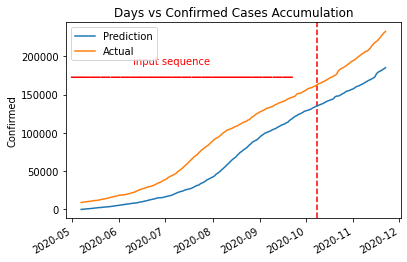

-----------
Alabama
2 / 50
(200, 1)


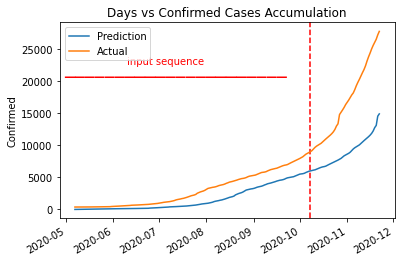

-----------
Alabama
3 / 50
(200, 1)


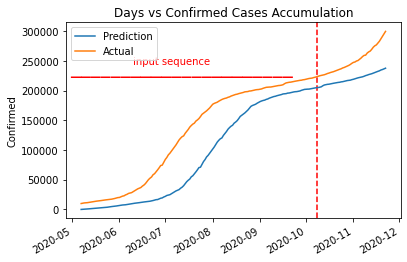

-----------
Alabama
4 / 50
(200, 1)


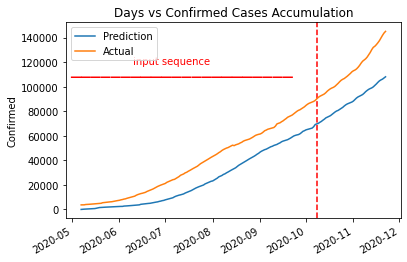

-----------
Alabama
5 / 50
(200, 1)


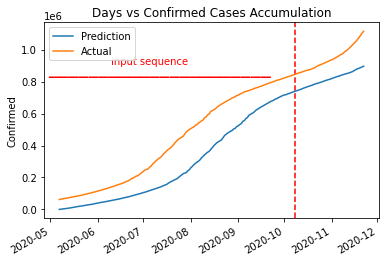

-----------
Alabama
6 / 50
(200, 1)


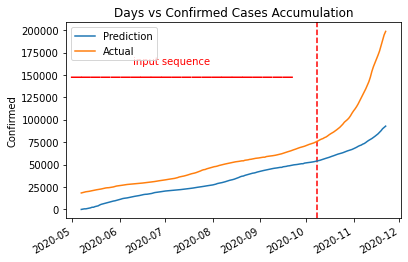

-----------
Alabama
7 / 50
(200, 1)


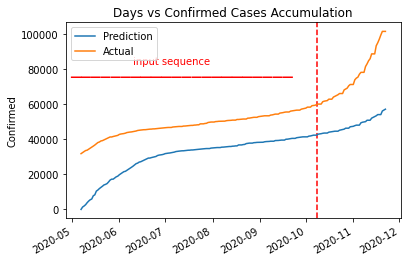

-----------
Alabama
8 / 50
(200, 1)


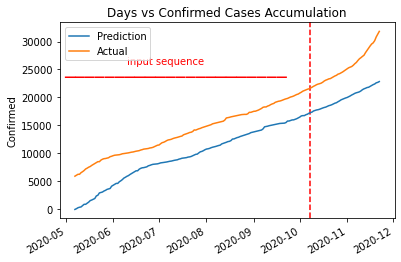

-----------
Alabama
9 / 50
(200, 1)


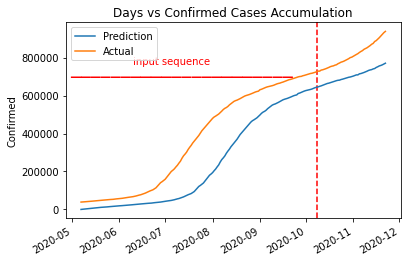

-----------
Alabama
10 / 50
(200, 1)


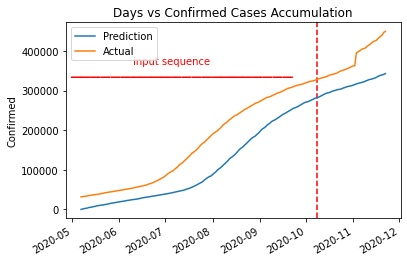

-----------
Alabama
11 / 50
(200, 1)


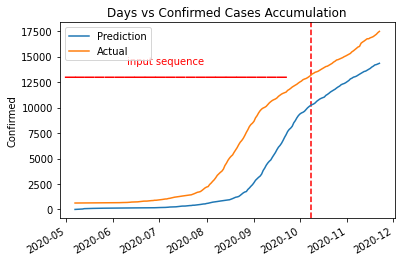

-----------
Alabama
12 / 50
(200, 1)


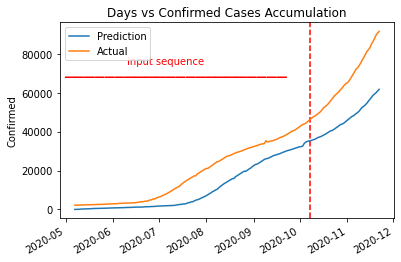

-----------
Alabama
13 / 50
(200, 1)


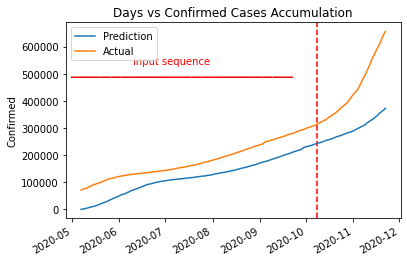

-----------
Alabama
14 / 50
(200, 1)


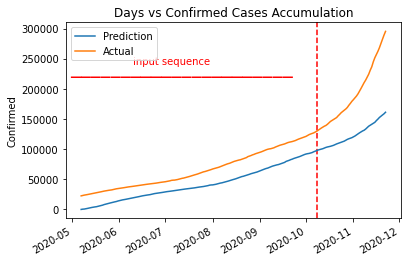

-----------
Alabama
15 / 50
(200, 1)


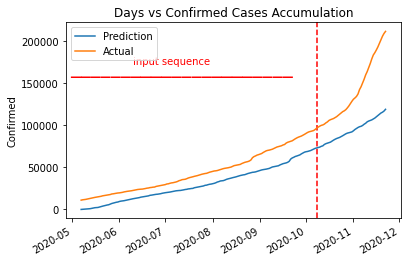

-----------
Alabama
16 / 50
(200, 1)


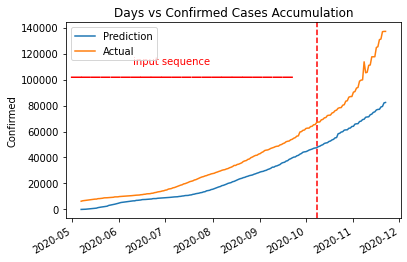

-----------
Alabama
17 / 50
(200, 1)


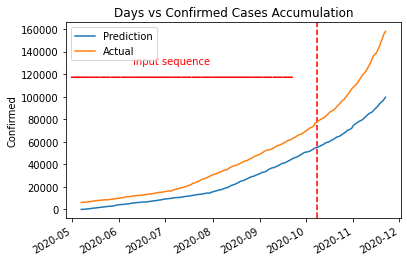

-----------
Alabama
18 / 50
(200, 1)


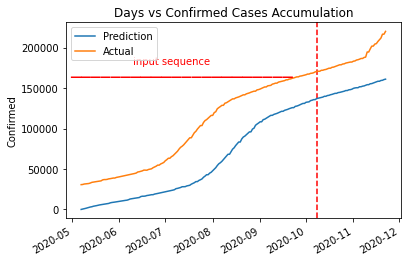

-----------
Alabama
19 / 50
(200, 1)


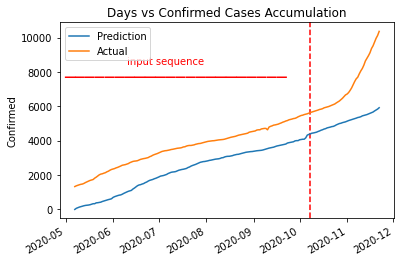

-----------
Alabama
20 / 50
(200, 1)


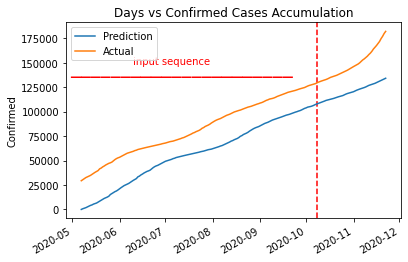

-----------
Alabama
21 / 50
(200, 1)


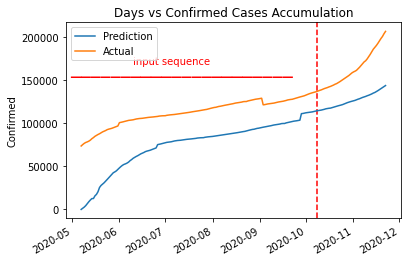

-----------
Alabama
22 / 50
(200, 1)


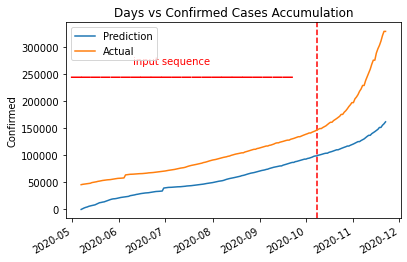

-----------
Alabama
23 / 50
(200, 1)


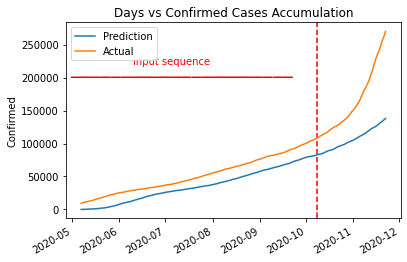

-----------
Alabama
24 / 50
(200, 1)


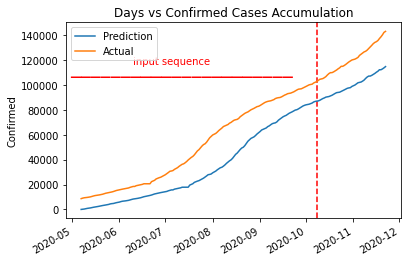

-----------
Alabama
25 / 50
(200, 1)


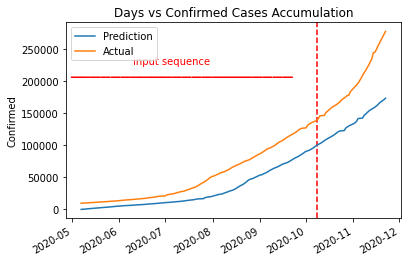

-----------
Alabama
26 / 50
(200, 1)


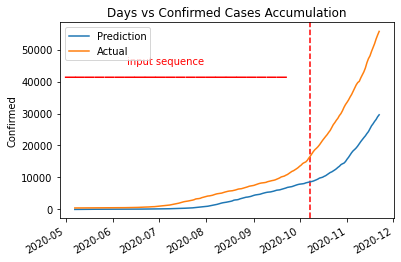

-----------
Alabama
27 / 50
(200, 1)


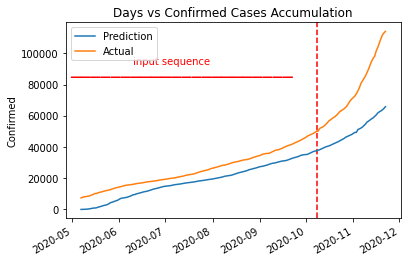

-----------
Alabama
28 / 50
(200, 1)


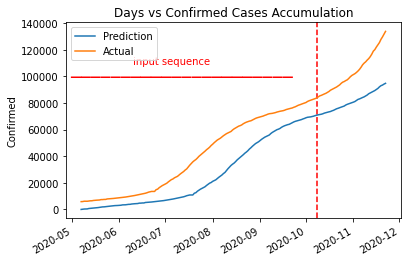

-----------
Alabama
29 / 50
(200, 1)


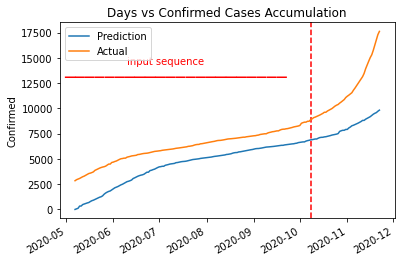

-----------
Alabama
30 / 50
(200, 1)


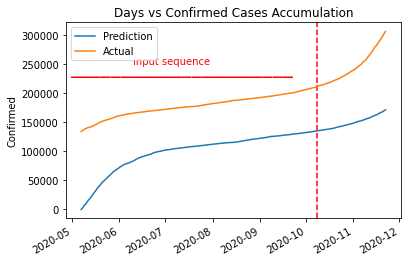

-----------
Alabama
31 / 50
(200, 1)


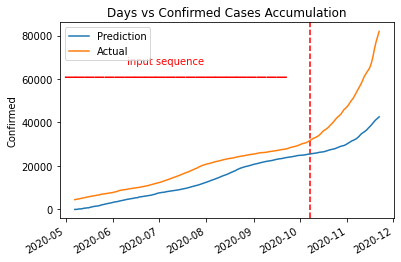

-----------
Alabama
32 / 50
(200, 1)


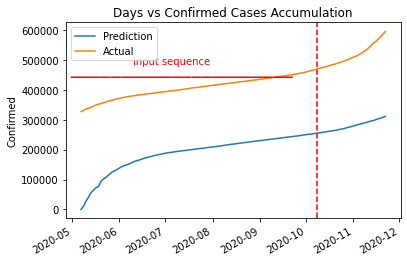

-----------
Alabama
33 / 50
(200, 1)


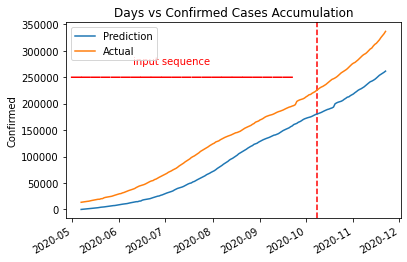

-----------
Alabama
34 / 50
(200, 1)


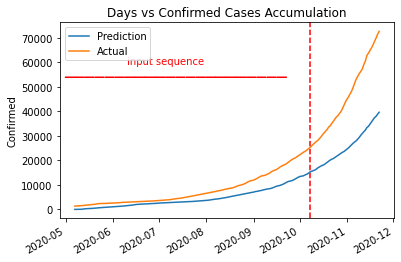

-----------
Alabama
35 / 50
(200, 1)


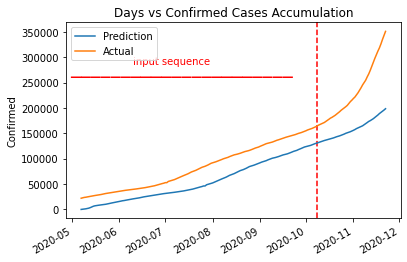

-----------
Alabama
36 / 50
(200, 1)


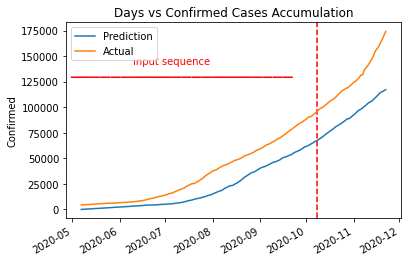

-----------
Alabama
37 / 50
(200, 1)


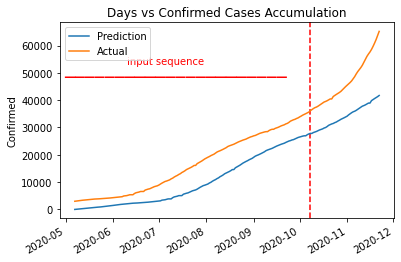

-----------
Alabama
38 / 50
(200, 1)


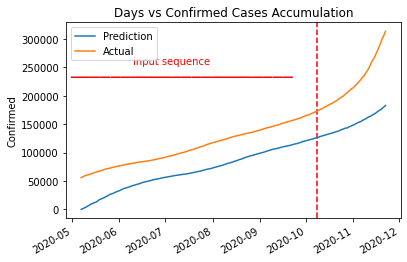

-----------
Alabama
39 / 50
(200, 1)


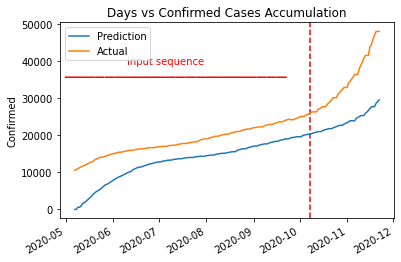

-----------
Alabama
40 / 50
(200, 1)


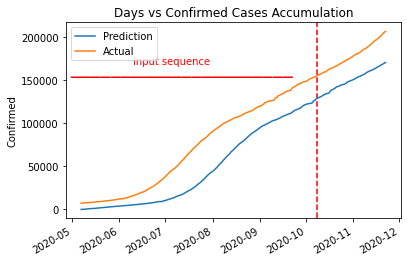

-----------
Alabama
41 / 50
(200, 1)


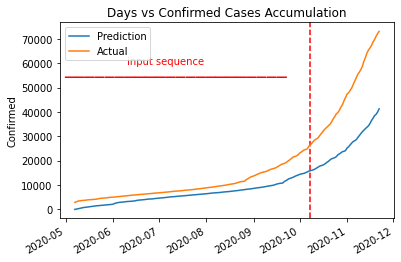

-----------
Alabama
42 / 50
(200, 1)


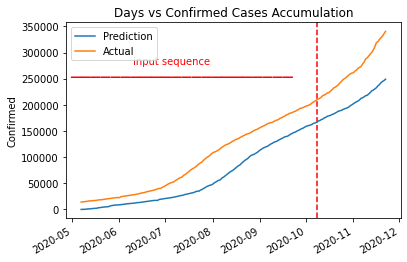

-----------
Alabama
43 / 50
(200, 1)


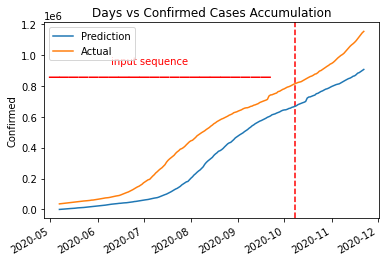

-----------
Alabama
44 / 50
(200, 1)


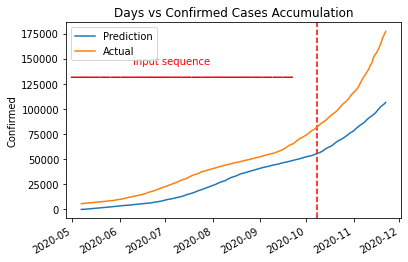

-----------
Alabama
45 / 50
(200, 1)


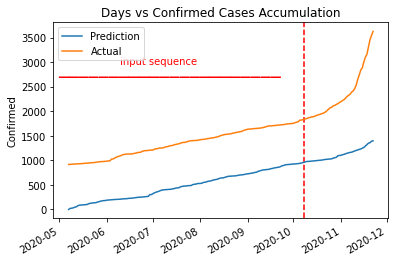

-----------
Alabama
46 / 50
(200, 1)


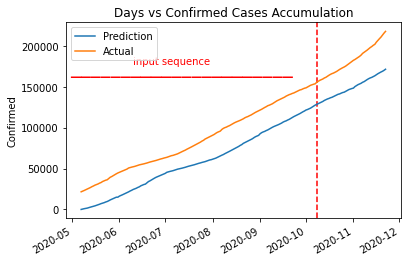

-----------
Alabama
47 / 50
(200, 1)


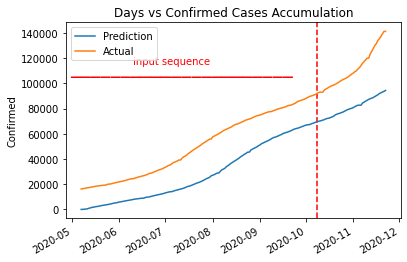

-----------
Alabama
48 / 50
(200, 1)


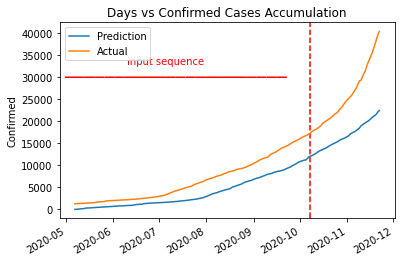

-----------
Alabama
49 / 50
(200, 1)


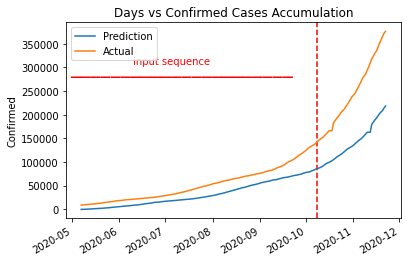

-----------
Alabama
50 / 50
(200, 1)


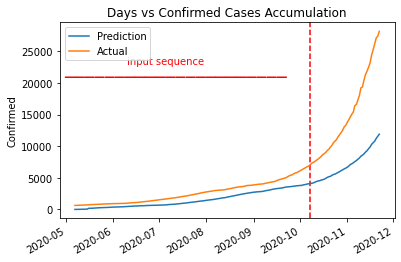

In [ ]:
state_list = list(df3["Province_State"].unique())
for i in range(len(state_list)):
  print("-----------")
  print(state_list[i])
  print(i+1,"/",len(state_list))
  test_states(state_list[i])


In [ ]:
#data2x=data2[~(data2.confirmed==0)]
data2x=data2
truth = data2

data2x.values[0:len(data2x),0]=np.insert(np.diff(data2x.values[0:len(data2x),0]),0,0)
data2x=scaler.transform(data2x) 


X_test = np.expand_dims(data2x, axis=0)
print (X_test.shape)
mv_net.init_hidden(1)


lstm_out = mv_net(torch.tensor(X_test[:,:140,:],dtype=torch.float32).cuda())
lstm_out=lstm_out.reshape(1,200,1).cpu().data.numpy()

# print (data2x[:155,0],lstm_out)
actual_predictions = scaler.inverse_transform(np.tile(lstm_out, (1, 1, 2))[0])[:,0]

# print (data2.values[:155,0],actual_predictions)

#actual_predictions=lstm_out


#save prediction
with open('./predict_indo8.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(pd.Series(actual_predictions), f,protocol=2)


(1, 200, 2)


Index(['05-07-2020', '05-08-2020', '05-09-2020', '05-10-2020', '05-11-2020',
       '05-12-2020', '05-13-2020', '05-14-2020', '05-15-2020', '05-16-2020',
       ...
       '11-13-2020', '11-14-2020', '11-15-2020', '11-16-2020', '11-17-2020',
       '11-18-2020', '11-19-2020', '11-20-2020', '11-21-2020', '11-22-2020'],
      dtype='object', name='Date', length=200)
DatetimeIndex(['2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10',
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-16',
               ...
               '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16',
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-21', '2020-11-22'],
              dtype='datetime64[ns]', length=200, freq='D')
(200, 1)
MAPE:  2.6066775851875716


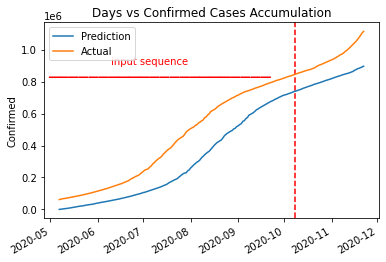

In [ ]:
#visualization####################################################################################################    
fig, ax = plt.subplots() 
plt.title('Days vs Confirmed Cases Accumulation')
plt.ylabel('Confirmed')

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

print (date.index)
date_list=pd.date_range(start=date.index[0],end=date.index[-1])
print (date_list)

plt.axvline(x=np.array(date_list)[154], color='r', linestyle='--')

ax.text(0.2*(left+right), 0.8*(bottom+top), 'input sequence',
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=10, color='red',
        transform=ax.transAxes)
ax.text(0.0125*(left+right), 0.77*(bottom+top), '______________________',
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=20, color='red',
        transform=ax.transAxes)



sumpred=np.cumsum(np.absolute(actual_predictions))

print (date.values.shape) 
print ("MAPE: ",100 * np.mean(np.absolute(date.Confirmed[-25:]-sumpred[-25:]-136186) / date.Confirmed[-25:]))          
# plt.plot(date.values[-225:],np.cumsum(data2.Confirmed.values[-225:]))
plt.plot(np.array(date_list),sumpred,label='Prediction')
plt.plot(np.array(date_list),date.Confirmed,label='Actual')
plt.xticks(rotation=90)
fig.autofmt_xdate()
plt.legend(loc=2)
plt.show() 
# 140 60

In [ ]:

print(i_m)

136186


In [ ]:

math.floor(date.Confirmed[-1]-sumpred[-1])

218309

In [ ]:
print(min)

2.6066775851875716


In [ ]:

# California: 2.6066775851875716
# Texas 2.6784034071706566

145908.625